<h1>Analyzing OpenStreetMap Road Network with PyG, NetworkX, and Graph Neural Networks</h1>
author: Aditi Jain (aditij@google.com) <br>
CS224W Autumn 2021 Final Project

This colab is broken up into 5 main sections:
*  Representating the road network as a graph and introducing the dataset
*  Exploring common node features like node centrality and average node degree
*  Presenting the classification task and computing feature and label distributions for dataset
*  Defining and training the model
*  Implementing a baseline MLP model

### Set-Up

Download PyTorch Geometric. Follow instructions [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html) if you run into issues.

In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.10.0+cu111


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 2.9 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 2.7 MB/s 
     |████████████████████████████████| 325 kB 5.2 MB/s 
     |████████████████████████████████| 407 kB 50.4 MB/s 
     |████████████████████████████████| 41 kB 574 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=29f423bf6473a84b802cb8aaf974fa419fe38ccada738d5f0b901329867eae0d
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric


Download manhatten.graphml and newyork.graphml from https://www.kaggle.com/crailtap/street-network-of-new-york-in-graphml. Upload the files to your Google Drive to a new folder titled OSM.

manhatten.graphml is great for small-scale analysis, while newyork.graphml is more suitable for training a model.



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/OSM

Mounted at /content/drive
/content/drive/MyDrive/OSM


In [ ]:
# Verify that manhatten.graphml and newyork.graphml are present.
%ls

manhatten.graphml  newyork.graphml


### Imports

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch_geometric
from torch_geometric.loader import NeighborSampler
import torch.nn.functional as F

# Road Network as a Graph

This section introduces the dataset.

For the rest of this colab, you may choose to work with either manhatten.graphml or newyork.graphml. The schemas are identical. [GraphML](http://graphml.graphdrawing.org/) is a standard file format for graphs, and thus reading is supported via NetworkX.

In [ ]:
newyork = nx.readwrite.graphml.read_graphml('newyork.graphml')
print(newyork)

MultiDiGraph named 'New York, USA' with 54128 nodes and 142123 edges


Nodes in this graph are real-world *intersections*, and directed edges are *road segments* where the edge direction indicates the direction of traffic.

You'll see that the underlying graph is a [MultiDiGraph](https://networkx.org/documentation/stable/reference/classes/multidigraph.html) which is a graph type that supports self-loops and parallel edges. There are O(10) such self-loops and parallel edges (likely due to user errors), so we will remove these using the nx.DiGraph constructor.

In [ ]:
newyork = nx.DiGraph(newyork)
print(newyork)

DiGraph named 'New York, USA' with 54128 nodes and 141673 edges


While we can't visualize the entire New York road network, let's look at the 4-hop radius around a single node (with OSM node id '42467335').

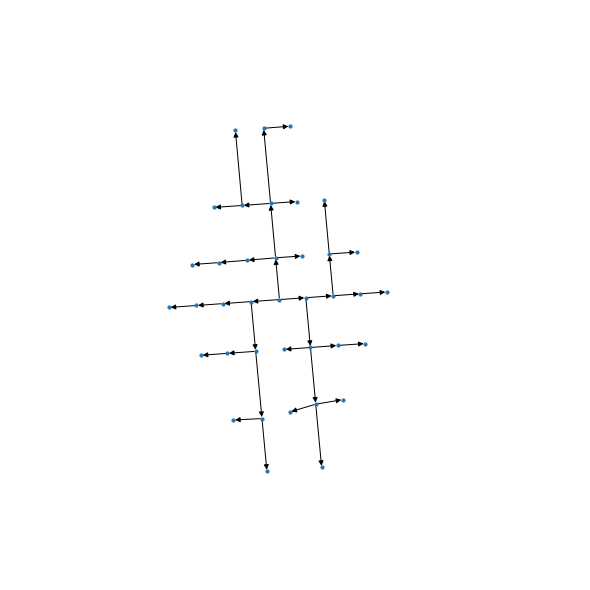

In [ ]:
edges_from_bfs = nx.algorithms.traversal.bfs_edges(newyork, '42467335', depth_limit=4)
subgraph = newyork.edge_subgraph(edges_from_bfs)
# We're going to use the actual latitudes and longitudes to draw the graph!
latitudes = [(u, y) for (u, y) in nx.get_node_attributes(subgraph, 'y').items()]
longitudes = [(u, x) for (u, x) in nx.get_node_attributes(subgraph, 'x').items()]
# latitudes and longitudes are stored as a strings, but nx pos needs floats.
pos = {u:(float(x),float(y)) for ((u,y), (u,x)) in zip(latitudes, longitudes)}
plt.figure(1, figsize=(8,8))
nx.draw(subgraph, pos=pos, node_size=10)
plt.show()

To view what intersection the central node corresponds to in the real world, let us look up the latitude and longitude from the node attribute dictionary.

In [ ]:
latitude = newyork.nodes['42467335']['y']
longitude = newyork.nodes['42467335']['x']
print("lat,lng is: {},{}".format(latitude, longitude))

lat,lng is: 40.655398,-73.929762


Then, paste this directly into Google Maps to find the intersection (looks like it's in Brooklyn at the corner of [E 51st St and Lenox Rd](https://www.google.com/maps/place/40%C2%B039'19.4%22N+73%C2%B055'47.1%22W/@40.6544862,-73.9312461,16.91z/data=!4m5!3m4!1s0x0:0x1a5250eae71a17de!8m2!3d40.655398!4d-73.929762))!



Now that we're clear on nodes (intersections) and edges (road segments), let's move on to studying the node and edge attributes, or properties, available in the dataset.

In [ ]:
# Node (Intersection) Features
all_node_keys = list(list(newyork.nodes[n].keys()) for n in newyork.nodes())
all_node_keys = set(np.concatenate(all_node_keys).flat)
all_node_keys

{'highway', 'osmid', 'ref', 'x', 'y'}

Any attribute name can be looked up in [OpenStreetMap Wiki](https://wiki.openstreetmap.org/wiki/Main_Page). As you found out before, 'x' and 'y' are the longitude and latitude of the intersection, in degrees. 'osmid' is the OSM unique ID, 'highway' tells us generally what's going on at the intersection (e.g. is there a traffic light), and 'ref' is a (not very well-documented) reference to something. The takeaway from the node attributes is that we don't have too many! Down the line, we'll synthesize our own attributes (e.g. degree, centrality) to close the gap.

In [ ]:
# Edge (Road Segment) Features
all_edge_keys = list(list(newyork.edges[e].keys()) for e in newyork.edges())
all_edge_keys = set(np.concatenate(all_edge_keys).flat)
all_edge_keys

{'access',
 'bridge',
 'geometry',
 'highway',
 'key',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'ref',
 'service',
 'tunnel',
 'width'}

These attribute names speak for themselves and become clearer upon inspecting the data. For example, 'maxspeed' the speed limit on the road segment, 'length' is the length in meters, and 'lanes' is the number of lanes.

In the next two sections, we'll look at (1) calculating more node attributes, and (2) computing the coverage of the attributes on the entire dataset.

# Traditional Node Features

This section explores node statistics like average degree and closeness centrality. It can be useful to compute these statistics as a step in getting to know our graph dataset better.

In graph-speak, average degree tells us, on average, how many (out or in) directed edges are adjacent to a node. For a directed graph, the formula is |E| / |N|, or total number of edges divided by total number of nodes. This makes sense, because each edge contributes exactly 1 to the total out degree (or total in degree).

In "road network"-speak, we can guess that the average degree will be anywhere from 2-4. Let's find out:

In [ ]:
# Average Degree
newyork.number_of_edges() / newyork.number_of_nodes()

2.6173699379249187

(array([4.5000e+01, 6.8900e+03, 0.0000e+00, 1.5394e+04, 0.0000e+00,
        2.3329e+04, 8.3500e+03, 0.0000e+00, 1.1200e+02, 8.0000e+00]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

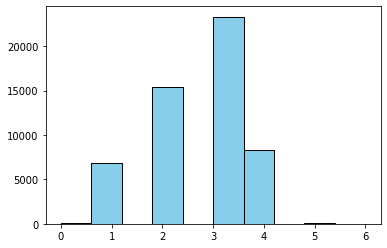

In [ ]:
# Histogram of out degree.
out_degrees = [v for (k,v) in newyork.out_degree]
plt.hist(out_degrees, color = 'skyblue', lw=1, ec="black")

[Centrality measurements](http://web.stanford.edu/class/cs224w/slides/02-tradition-ml.pdf) like Eigenvector centrality, Betweenness Centrality, and Closeness Centrality all attempt to characterize the "importance" of a node in network. Where these centrality measurements differ is in how they determine "importance". We'll look at Betweenness Centrality and Closeness Centrality in the few code blocks.

## Betweenness Centrality

Betweenness centrality characterizes node importance as lying on many shortest paths between other nodes. In the road network, we'd imagine this to be an important intersection that many cars have to cross while taking the shortest path from point A to point B. Let's see this in practice using built-in NetworkX functions:

In [ ]:
# Betweenness Centrality. Since the algorithm is very slow, let's run on
# Manhatten, instead of the entire state. (Takes ~3 min to run)
manhatten = nx.readwrite.graphml.read_graphml('manhatten.graphml')
manhatten = nx.DiGraph(manhatten)
betweenness_centrality = nx.algorithms.centrality.betweenness_centrality(manhatten)

In [ ]:
# Let's find the intersection in Manhatten that's on the most shortest paths!
betweenness_max_node = max(betweenness_centrality, key=betweenness_centrality.get)
print("Betweeness Centrality intersection is at: {},{}".format(manhatten.nodes[betweenness_max_node]['y'],
                                                               manhatten.nodes[betweenness_max_node]['x']))

Betweeness Centrality intersection is at: 40.7952534,-73.9732066


It would be very interesting to find out if [W 96th St and West End Ave](https://www.google.com/maps/place/40%C2%B047'42.9%22N+73%C2%B058'23.5%22W/@40.7959464,-73.9739047,18.49z/data=!4m5!3m4!1s0x0:0xe469b77138b578a4!8m2!3d40.7952534!4d-73.9732066) is truly a busy intersection!

## Closeness Centrality

Closeness centrality defines importance slightly differently. It says that node is important if it has the smallest shortest path lengths to all other nodes. In the road network, I'm imagining this to be an intersection which is is extremely central (location-wise). Let's find out.

In [ ]:
# Closeness Centrality. (Takes ~1 min to run)
closeness_centrality = nx.algorithms.centrality.closeness_centrality(manhatten)

In [ ]:
# Let's find the intersection in Manhatten that's closest to all other intersections.
closeness_max_node = max(closeness_centrality, key=closeness_centrality.get)
print("Closeness Centrality intersection is at: {},{}".format(manhatten.nodes[closeness_max_node]['y'],
                                                              manhatten.nodes[closeness_max_node]['x']))

Closeness Centrality intersection is at: 40.7474423,-73.9688174


The intersection is actually on the [outer edge](https://www.google.com/maps/place/40%C2%B044'50.8%22N+73%C2%B058'07.7%22W/@40.7335836,-73.9882072,12.8z/data=!4m5!3m4!1s0x0:0xaf0c4057ea31f7e9!8m2!3d40.7474423!4d-73.9688174) of Manhatten. However, it is on FDR Drive which is very well-connected to the rest of Manhatten. Out of sheer curiosity, let's find the intersection with the smallest closeness centrality importance.

In [ ]:
# Let's find the intersection in Manhatten that's closest to all other intersections.
closeness_min_node = min(closeness_centrality, key=closeness_centrality.get)
print("Closeness Centrality intersection is at: {},{}".format(manhatten.nodes[closeness_min_node]['y'],
                                                              manhatten.nodes[closeness_min_node]['x']))

Closeness Centrality intersection is at: 40.847668,-73.929669


How interesting! It's an [intersection](https://www.google.com/maps/place/40%C2%B050'51.6%22N+73%C2%B055'46.8%22W/@40.8498388,-73.9570406,14.11z/data=!4m5!3m4!1s0x0:0x861056dae5f7fd17!8m2!3d40.847668!4d-73.929669) adjacent to an off-ramp at almost the northern most region of Manhatten. That makes sense. Let's get back to our dataset now, and take a deeper look at the edge feature distributions.

# Dataset Statistics

This section will get you very familiar with the edge-level (or road-level) features present in the dataset.

In [ ]:
# A helper function to count the number of edges with a particular feature
# present.
def countEdgesWithFeature(feature_dict, feature_key):
  count = 0
  for k,v in feature_dict.items():
    if feature_key in v:
      count += 1
  return count

In [ ]:
# Total number of edges
E = len(newyork.edges())
print(E)

141673


The following code computes, for each attribute, the percent of edges which have the feature available. Because OSM is based on user contributions, it's understandable to have high rates of missing features.

In [ ]:
for attribute_name in all_edge_keys:
  count = countEdgesWithFeature(newyork.edges(), attribute_name)
  print("{}: {} (Percentage: {:.1%})".format(attribute_name, count, count/E))

service: 17 (Percentage: 0.0%)
key: 141673 (Percentage: 100.0%)
access: 413 (Percentage: 0.3%)
maxspeed: 7661 (Percentage: 5.4%)
highway: 141673 (Percentage: 100.0%)
bridge: 2074 (Percentage: 1.5%)
lanes: 12808 (Percentage: 9.0%)
name: 137766 (Percentage: 97.2%)
length: 141673 (Percentage: 100.0%)
geometry: 37222 (Percentage: 26.3%)
oneway: 141673 (Percentage: 100.0%)
tunnel: 177 (Percentage: 0.1%)
width: 33 (Percentage: 0.0%)
ref: 3198 (Percentage: 2.3%)
osmid: 141673 (Percentage: 100.0%)


Next, let's take a closer look at features with a non-trivial presence in the dataset
* [Highway](https://wiki.openstreetmap.org/wiki/Key:highway): Indicates the importance of the road within the road network as a whole (e.g. residential vs connecter segment vs primary highway.
* [Lanes](https://wiki.openstreetmap.org/wiki/Lanes): Number of traffic lanes.
* [Max Speed](https://wiki.openstreetmap.org/wiki/Key:maxspeed): Legal maximum speed limit
* [One-Way](https://wiki.openstreetmap.org/wiki/Key:oneway): Whether or not the road segment is one-way
* [Length](https://wiki.openstreetmap.org/wiki/Key:length): Road segment length in meters.

To explore the data by attribute, we'll first create a dictionary mapping each edge feature to a dictionary of the values present.

In [ ]:
edge_attribute_categorical = defaultdict(lambda: defaultdict(int))
road_lengths = []
for edge_attributes in newyork.edges.values():
  for attribute_name, attribute_value in edge_attributes.items():
    if attribute_name in {"highway", "lanes", "maxspeed", "oneway"}:
      edge_attribute_categorical[attribute_name][attribute_value] += 1
    if attribute_name == "length":
      road_lengths.append(float(attribute_value))

Let's look at 'highway' first. You'll see that there are a few edges which have multiple road classes present. In later sections of this colab, we'll ignore such values.

In [ ]:
# Highway
edge_attribute_categorical["highway"]

defaultdict(int,
            {"[u'motorway', u'motorway_link']": 14,
             "[u'motorway', u'primary']": 1,
             "[u'motorway_link', u'secondary']": 3,
             "[u'motorway_link', u'secondary_link']": 1,
             "[u'motorway_link', u'tertiary']": 1,
             "[u'primary', u'motorway_link']": 1,
             "[u'primary', u'secondary']": 4,
             "[u'primary', u'tertiary']": 2,
             "[u'primary', u'trunk']": 2,
             "[u'primary_link', u'residential']": 1,
             "[u'residential', u'motorway_link']": 4,
             "[u'residential', u'secondary']": 9,
             "[u'residential', u'secondary_link']": 1,
             "[u'residential', u'tertiary']": 24,
             "[u'residential', u'trunk_link']": 2,
             "[u'secondary', u'secondary_link']": 3,
             "[u'tertiary', u'motorway_link']": 1,
             "[u'tertiary', u'secondary']": 2,
             "[u'tertiary_link', u'tertiary']": 2,
             "[u'tertiary_li

In [ ]:
# Lanes
edge_attribute_categorical["lanes"]

defaultdict(int,
            {'1': 1488,
             '2': 5726,
             '2; 4': 2,
             '3': 1841,
             '4': 2171,
             '4; 3': 3,
             '5': 369,
             '6': 197,
             '7': 50,
             "[u'1', u'2']": 46,
             "[u'1', u'3']": 1,
             "[u'1', u'4']": 1,
             "[u'2', u'4']": 39,
             "[u'2', u'5']": 6,
             "[u'3', u'2', u'4']": 7,
             "[u'3', u'2']": 195,
             "[u'3', u'4']": 175,
             "[u'3', u'5', u'4']": 3,
             "[u'3', u'5']": 9,
             "[u'3', u'6']": 8,
             "[u'4', u'6']": 18,
             "[u'4', u'7', u'6']": 4,
             "[u'4', u'7']": 2,
             "[u'5', u'4', u'6']": 2,
             "[u'5', u'4', u'7']": 2,
             "[u'5', u'4']": 379,
             "[u'5', u'6']": 6,
             "[u'7', u'6']": 56,
             "[u'8', u'6']": 2})

In [ ]:
# Max Speed (Speed Limit)
edge_attribute_categorical["maxspeed"]

defaultdict(int,
            {'10 mph': 1,
             '120 mph': 4,
             '15 mph': 17,
             '20 mph': 362,
             '25 mph': 5553,
             '30 mph': 786,
             '35 mph': 351,
             '39 mph': 2,
             '40 mph': 99,
             '45 mph': 80,
             '5 mph': 1,
             '50 mph': 375,
             '55 mph': 1,
             "[u'10 mph', u'40 mph']": 1,
             "[u'25 mph', u'30 mph']": 5,
             "[u'25 mph', u'39 mph']": 2,
             "[u'25 mph', u'40 mph']": 4,
             "[u'30 mph', u'35 mph']": 3,
             "[u'30 mph', u'40 mph']": 1,
             "[u'35 mph', u'40 mph']": 1,
             "[u'40 mph', u'35 mph']": 1,
             "[u'45 mph', u'50 mph']": 7,
             "[u'55 mph', u'50 mph']": 4})

In [ ]:
# One-Way
edge_attribute_categorical["oneway"]

defaultdict(int, {'False': 104076, 'True': 37597})

(array([3.4600e+03, 6.2130e+03, 7.0000e+03, 7.3390e+03, 7.3010e+03,
        4.0601e+04, 1.2921e+04, 6.8250e+03, 5.3630e+03, 5.0190e+03,
        5.1760e+03, 4.6370e+03, 3.9900e+03, 3.4830e+03, 4.5420e+03,
        2.7770e+03, 3.9110e+03, 2.4290e+03, 1.8650e+03, 1.8490e+03,
        8.7200e+02, 5.9800e+02, 4.9300e+02, 2.9700e+02, 2.2300e+02,
        2.0100e+02, 1.4800e+02, 1.4300e+02, 1.4100e+02, 1.3200e+02,
        1.3800e+02, 1.0400e+02, 6.5000e+01, 8.9000e+01, 9.1000e+01,
        6.0000e+01, 7.0000e+01, 5.7000e+01, 5.9000e+01, 3.6000e+01,
        6.3000e+01, 5.3000e+01, 2.7000e+01, 3.6000e+01, 3.6000e+01,
        2.2000e+01, 2.6000e+01, 2.3000e+01, 2.3000e+01, 1.1000e+01]),
 array([  0.,  14.,  28.,  42.,  56.,  70.,  84.,  98., 112., 126., 140.,
        154., 168., 182., 196., 210., 224., 238., 252., 266., 280., 294.,
        308., 322., 336., 350., 364., 378., 392., 406., 420., 434., 448.,
        462., 476., 490., 504., 518., 532., 546., 560., 574., 588., 602.,
        616., 630., 64

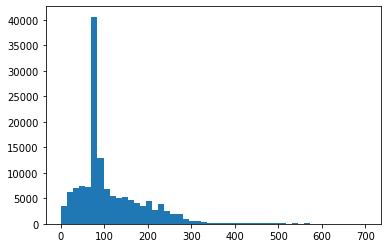

In [ ]:
# Road Length
plt.hist(road_lengths, bins=50, range=(0,700))

In [ ]:
# Compute mean and standard deviation of road length feature for normalization
# in the model
mean =  sum(road_lengths) / len(road_lengths)
stdev = (sum([((x - mean) ** 2) for x in road_lengths]) / len(road_lengths))**(0.5)
print("mean: ", mean, " and stdev: ", stdev)

mean:  118.59536848513265  and stdev:  108.47075106013754


At this point, you should have a good handle on the formulation of a road network as a graph, how to synthesize node features (e.g. centrality), and the edge features present in the dataset. In the next section, you'll see an example of what we can do with all this data!

# Lane Count Prediction

Earlier, we saw that lane counts were only present in 9% of the entire dataset. Lane count is an important feature for applications like self-driving cars, localization, and navigation (e.g. "Turn right from the second-from-the-right lane"). While the true lane count is measured most directly from lane marker stripes, we may be able to leverage road network structure and features like road length and road class to predict number of lanes.

## Building Intuition

Let's go back to that subgraph we were looking at before (4-hop neighborhood around node '42467335'). This time, we'll color the edges by the lane count.

['tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:orange', 'tab:orange', 'tab:orange', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:red', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:orange', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:red', 'tab:grey', 'tab:orange', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey', 'tab:grey']


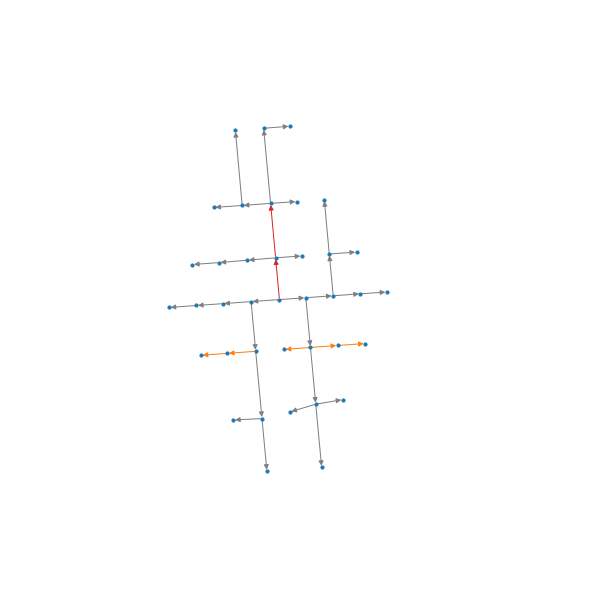

In [ ]:
lane_count_attr = nx.get_edge_attributes(subgraph, "lanes")

lane_count_to_color = {1: "tab:red", 2: "tab:orange", 3: "tab:olive",
                        4: "tab:green", 5: "tab:blue", 6: "tab:purple",
                        7: "tab:yellow"}
lane_edge_colors=[]
for (u,v) in subgraph.edges:
  lane_count_color = "tab:grey"  # unknown lane count
  try:
    lane_count = int(lane_count_attr[(u,v)])
    lane_count_color = lane_count_to_color[lane_count]
  except:
    pass
  lane_edge_colors.append(lane_count_color)

plt.figure(1, figsize=(8,8))
nx.draw(subgraph, pos=pos, edge_color=lane_edge_colors, node_size=10)
plt.show()

Red corresponds to 1 lane and orange corresponds to 2 lanes. On the rest of the (grey) lanes, we do not have any ground truth labels. Now, let's see what happens when we overlay road class ('highway' attribute). What we're looking for is a correlation between the road class and the lane count.

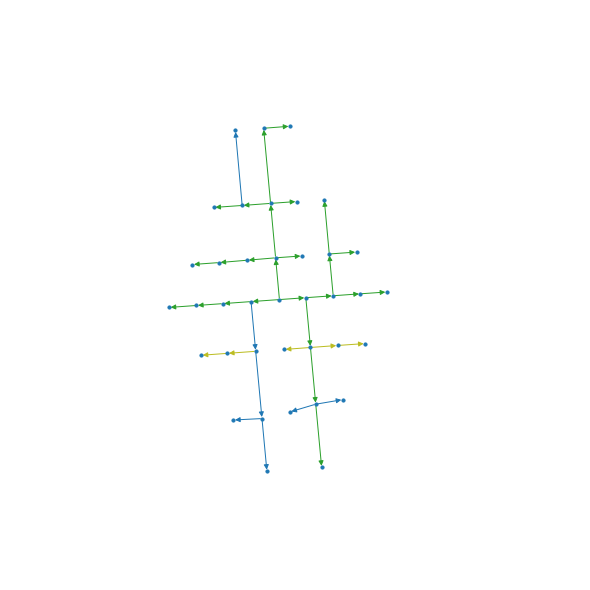

In [ ]:
road_class_attr = nx.get_edge_attributes(subgraph, "highway")

road_class_to_color = {'motorway': "tab:red", "motorway_link": "tab:orange", "primary": "tab:olive",
                        "residential": "tab:green", "secondary": "tab:blue", "secondary_link": "tab:purple",
                        "tertiary": "tab:yellow", "tertiary_link": "tab:pink", "trunk": "tab:brown",
                        "trunk_link": "tab:turquoise"}
road_class_edge_colors=[]
for (u,v) in subgraph.edges:
  road_class_color = "tab:grey"
  try:
    road_class_color = road_class_to_color[road_class_attr[(u,v)]]
  except:
    pass
  road_class_edge_colors.append(road_class_color)

plt.figure(1, figsize=(8,8))
nx.draw(subgraph, pos=pos, edge_color=road_class_edge_colors, node_size=10)
plt.show()

Notice that the the two roads with 2 lanes (orange in the above graph) notably stand out as having road class "tertiary" (colored yellow). And further, the two roads with just 1 lane (red above), have road class residential. This tells us that road class might be a useful attribute in predicting the lane count. In the next section, we'll formalize the machine learning task.

## Building the Lane Count prediction dataset

### Problem Formulation: Dual Graph

In this section, we'll construct our dataset for lane count prediction. As background on Graph Neural Networks (GNNs), when using GNNs we formulate our task in terms of node classification, link prediction/edge classification, or graph classification. In our dataset, as-is, the level on which we want to make the prediction is edge-level (or road-segment-level).

We could choose to implement lane count prediction as an edge classification problem, but we're actually going to invert the graph so that road segments become nodes and intersections become edges (where one intersection actually maps to many edges in the new graph). There are two reasons we're choosing to do this inversion:



1.   The [torch_geometric.data.sampler.NeighborSampler](https://pytorch-geometric.readthedocs.io/en/1.6.1/_modules/torch_geometric/data/sampler.html) which is going to subsample our road network into training examples, operates at the node-level. By using node classification, the (BFS) depth for the Neighborhood Sampler directly equals the number of Message-Passing layers in our model.
2.   If we model intersections as nodes, then we won't have very meaningful features for the node embeddings (just degree, centrality, and other synthetic features). The really interesting features (road length, road class) are the edge-level. Edge attributes are supported by some GNN layers (e.g. [GATConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv)) but not others ([GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)).



In [ ]:
# Helper function to return x (features) and y (label) given the edge attributes
# in the original graph.
def featureVectorAndLabel(edge_attr):
  featureVector = []

  # Lane Count. -1 is a placeholder for missing or malformed lane count.
  label = -1 if 'lanes' not in edge_attr else edge_attr['lanes']
  try:
    label = int(label) - 1  # 0-index the labels (1 lane = class 0)
  except ValueError:
    label = -1

  # Speed Limit
  maxspeed = -1 if 'maxspeed' not in edge_attr else edge_attr['maxspeed']
  try:
    maxspeed = int(maxspeed.split()[0])
    maxspeed = maxspeed / 100.0  # Normalize
  except:
    maxspeed = -1
  featureVector.append(maxspeed)

  # Road Length
  length = -1 if 'length' not in edge_attr else edge_attr['length']
  try:
    length = float(length)
    # Normalize
    length = (length - 118.59536848513265) / 108.47075106013754
  except ValueError:
    length = -1
  featureVector.append(length)

  # One-Way (originally stored as a bool)
  oneway = -1 if 'oneway' not in edge_attr else edge_attr['oneway']
  if oneway == "True":
    oneway = 1
  else:
    oneway = 0
  featureVector.append(oneway)

  # Road Type
  allowed_road_types = {'motorway': 0, "motorway_link": 1, "primary": 2,
                        "residential": 3, "secondary": 4, "secondary_link": 5,
                        "tertiary": 6, "tertiary_link": 7, "trunk": 8,
                        "trunk_link": 9}
  road_type = -1
  if 'highway' in edge_attr and edge_attr['highway'] in allowed_road_types:
    road_type = allowed_road_types[edge_attr['highway']]
  featureVector.append(road_type)
  return featureVector, label

In [ ]:
# Inverts nodes and edges, so this becomes a node classification problem.
# Each edge in the old graph is a node in the new graph.
# An edge in the new graph gets drawn between any two nodes (road segments)
# which were adjacent (connected by an intersection) in the original graph.
def getDualGraph(originalGraph):
  G = nx.DiGraph()
  for node in originalGraph.nodes:
    incoming_edges = originalGraph.in_edges(node, data=True)
    outgoing_edges = originalGraph.out_edges(node, data=True)

    for (u_incoming, v_incoming, incoming_edge_attr) in incoming_edges:
      for (u_outgoing, v_outgoing, outgoing_edge_attr) in outgoing_edges:

        new_incoming_node = u_incoming + "-" + v_incoming
        new_outgoing_node = u_outgoing + "-" + v_outgoing

        if new_incoming_node not in G:
          G.add_node(new_incoming_node)
          x, y = featureVectorAndLabel(incoming_edge_attr)
          # x and y are node attributes.
          nx.set_node_attributes(G, {new_incoming_node: {'x': x, 'y': y}})

        if new_outgoing_node not in G:
          G.add_node(new_outgoing_node)
          x, y = featureVectorAndLabel(outgoing_edge_attr)
          nx.set_node_attributes(G, {new_outgoing_node: {'x': x, 'y': y}})

        G.add_edge(new_incoming_node, new_outgoing_node)
        original_in_degree = originalGraph.in_degree(node)
        original_out_degree = originalGraph.out_degree(node)
        # edge_attr is the edge attributes (in_degree and out_degree).
        nx.set_edge_attributes(G, {(new_incoming_node, new_outgoing_node):
        {'edge_attr': [original_in_degree, original_out_degree]}})
  return G

G = getDualGraph(newyork)

The number of edges in the old graph should be exactly equal to the number of nodes in the new graph!

In [ ]:
print(newyork.number_of_edges() == G.number_of_nodes())

True


Recall that G is a nx.DiGraph(). Data in PyTorch Geometric are represented as [torch_geometric.data.Data](https://pytorch-geometric.readthedocs.io/en/1.3.2/modules/data.html). Luckily, torch_geometric has a converter from NetworkX which preserves edge connections (edge_index), and node and edge attributes:

In [ ]:
# Converts NetworkX graph to torch_geometric.data.Data
data = torch_geometric.utils.convert.from_networkx(G)

In [ ]:
data['x']

tensor([[-1.0000, -0.3365,  0.0000,  3.0000],
        [-1.0000,  0.4802,  0.0000,  3.0000],
        [-1.0000, -0.3365,  0.0000,  3.0000],
        ...,
        [-1.0000, -0.3654,  0.0000,  3.0000],
        [-1.0000, -0.3362,  0.0000,  3.0000],
        [-1.0000, -0.3362,  0.0000,  3.0000]])

'x' is the node feature vector, where the 4 attributes correspond to speed limit, road length, one-way, and road class, converted to numeric values. 'y' is the 0-indexed lane count label, where -1 is used as a placeholder value for missing label. Finally 'edge_attr' is the edge feature vector with two features, original graph's in-degree and original graph's out-degree. Before moving on, let's look at the label distribution. This an important step in determining if class imbalance will be a problem.

In [ ]:
labels = torch.masked_select(data.y, torch.where(data.y >= 0, True, False))

(array([1488., 5726., 1841., 2171.,  369.,  197.,   50.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

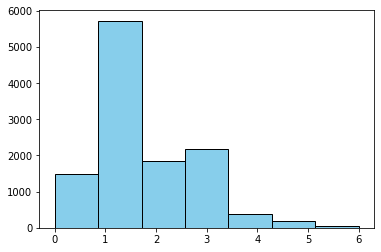

In [ ]:
plt.hist(labels, bins=7, color = 'skyblue', lw=1, ec="black")

In the next few section, we'll use PyTorch's NeighborSampler to create rooted node subgraphs for training.

### Sampling the Graph

The road network is very large, and we need to break it down into smaller pieces for training. The way this is done most commonly in research and industry is to take the K-Hop neighborhood around each node (road segment). For training, we will only construct these rooted subgraphs where we have ground truth (non-negative label). For inference, we'll do this for every single node in the original subgraph.

In [ ]:
# Nodes with lane count label present.
label_mask = torch.where(data.y >= 0, True, False)

In [ ]:
# 11,842 total nodes with a label.
torch.sum(label_mask == True)

tensor(11842)

In [ ]:
# Split into Train and Validation (80 / 20)
node_idx = label_mask.nonzero()
num_train = int(0.8 * len(node_idx))
shuffle = torch.randperm(node_idx.size(0))
train_idx = node_idx[shuffle[:num_train]]
val_idx = node_idx[shuffle[num_train:]]

print("Num train: ", len(train_idx))

Num train:  9473


**NeighborSampler Basics**: NeighborSampler samples the K-Hop neighborhood around nodes passed int through `node_idx`. K is specified through the `sizes` argument; each entry in `sizes` corresponds to the number of nodes which should be sampled at the i'th depth where -1 indicates taking all nodes at that depth. Finally, `drop_last` ensures that the number of nodes in the dataset is divisible by the `batch_size`.

In [ ]:
train_loader = NeighborSampler(data.edge_index, node_idx=train_idx,
                               sizes=[-1, -1], batch_size=64,
                               shuffle=True, num_workers=12, drop_last=True)

val_loader = NeighborSampler(data.edge_index, node_idx=val_idx,
                             sizes=[-1, -1], batch_size=64,
                             shuffle=True, num_workers=12, drop_last=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's get a better sense of how many nodes are in each batch. This can give us intuition into how long model training will take. Smaller graphs = faster training, but of course at a cost to accuracy if we think that a larger K-hop radius is more powerful to the model.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


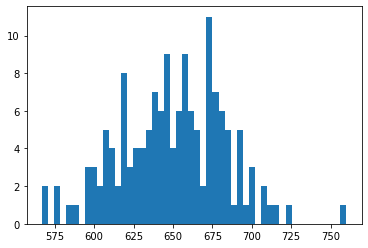

In [ ]:
# Histogram of number of nodes per batch.
num_nodes = []
for _, n_id, _ in train_loader:
  num_nodes.append(len(n_id))
plt.hist(num_nodes, 50)
plt.show()

## Build the Model

In this section, we'll construct the Graph Neural Network using PyTorch Geometric built-in GNN layers. Note that these are more or less plug-and-play layers.

In [ ]:
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv

# layer_name should be one of:
#   SAGEConv
#   GATConv
class Model(torch.nn.Module):
    def __init__(self, layer_name, input_dim, hidden_dim, output_dim, edge_dim, num_layers, dropout):
        super().__init__()


        # Convolutional Layers
        self.layer_name = layer_name
        layers = []
        if layer_name == "SAGEConv":
          layers = [SAGEConv(input_dim, hidden_dim)]
          for _ in range(num_layers-2):
            layers.append(SAGEConv(hidden_dim, hidden_dim))
          layers.append(SAGEConv(hidden_dim, output_dim))

        elif layer_name == "GATConv":
          layers = [GATConv(input_dim, hidden_dim, edge_dim=edge_dim)]
          for _ in range(num_layers-2):
            layers.append(GATConv(hidden_dim, hidden_dim, edge_dim=edge_dim))
          layers.append(GATConv(hidden_dim, output_dim, edge_dim=edge_dim))

        self.convs = torch.nn.ModuleList(layers)

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs, edge_attr):
      for i, (edge_index, e_id, size) in enumerate(adjs):
        x_target = x[:size[1]]  # Target nodes are always placed first.
        if self.layer_name == "SAGEConv":
          x = self.convs[i]((x, x_target), edge_index)
        elif self.layer_name == "GATConv":
          x = self.convs[i]((x, x_target), edge_index, edge_attr[e_id])
        if i < len(self.convs) - 1:
          x = F.relu(x)
          x = F.dropout(x, self.dropout, training=self.training)
      return x

## Training and Validation Loops

In [ ]:
# Returns dictionary of metrics with the following keys:
# correct: total items predicted correctly
# TP_k : # of True Positives for Label K
# FP_k : # of False Positives for Label K
# FN_k : # of False Negatives for Label K
def computeMetrics(predicted, actual):
  metrics = {}
  metrics['correct'] = int(predicted.eq(actual).sum())
  num_classes = 7
  for k in range(num_classes):
    positive_label = actual.eq(k)
    negative_label = torch.logical_not(positive_label)
    positive_prediction = predicted.eq(k)
    negative_prediction = torch.logical_not(positive_prediction)

    TP = float(torch.logical_and(positive_label, positive_prediction).sum())
    FP = float(torch.logical_and(negative_label, positive_prediction).sum())
    FN = float(torch.logical_and(positive_label, negative_prediction).sum())

    metrics['TP_' + str(k)] = TP
    metrics['FP_' + str(k)] = FP
    metrics['FN_' + str(k)] = FN

  return metrics

In [ ]:
# The Train function loops through all batches and computes the loss on the
# target node.
def train(model, data, train_idx, train_loader, optimizer):
  model.train()
  total_loss = 0
  metrics = defaultdict(float)

  for batch_size, n_id, adjs in train_loader:
    # len(adjs) = number of hops
    adjs = [adj.to(device) for adj in adjs]
    labels = data.y[n_id[:batch_size]]
    optimizer.zero_grad()
    out = model(data.x[n_id].float(), adjs, data.edge_attr.float())
    loss = F.cross_entropy(out, labels)
    loss.backward()
    optimizer.step()
    total_loss += float(loss)
    predictions = out.argmax(dim=-1)
    batch_metrics = computeMetrics(predictions, labels)
    # Bookkeeping
    metrics['total_correct'] += batch_metrics['correct']
    for k in range(7):
      metrics['total_TP_' + str(k)] += batch_metrics['TP_' + str(k)]
      metrics['total_FP_' + str(k)] += batch_metrics['FP_' + str(k)]
      metrics['total_FN_' + str(k)] += batch_metrics['FN_' + str(k)]

  metrics['total_loss'] = total_loss / len(train_loader)
  metrics['accuracy'] = metrics['total_correct'] / train_idx.size(0)
  for k in range(7):
    TP, FP, FN = metrics['total_TP_' + str(k)], metrics['total_FP_' + str(k)], metrics['total_FN_' + str(k)]
    metrics['precision_' + str(k)] = TP/(TP+FP) if TP+FP else 0
    metrics['recall_' + str(k)] = TP/(TP+FN) if TP+FN else 0

  return metrics

In [ ]:
# The Validation function simply runs inference on each node in the validation
# set.
def validate(model, data, val_idx, val_loader):
  total_loss = 0
  metrics = defaultdict(float)

  for batch_size, n_id, adjs in val_loader:
    adjs = [adj.to(device) for adj in adjs]
    out = model(data.x[n_id].float(), adjs, data.edge_attr.float())
    labels = data.y[n_id[:batch_size]]
    predictions = out.argmax(dim=-1)
    loss = F.cross_entropy(out, labels)
    total_loss += float(loss)
    batch_metrics = computeMetrics(predictions, labels)
    # Bookkeeping
    metrics['total_correct'] += batch_metrics['correct']
    for k in range(7):
      metrics['total_TP_' + str(k)] += batch_metrics['TP_' + str(k)]
      metrics['total_FP_' + str(k)] += batch_metrics['FP_' + str(k)]
      metrics['total_FN_' + str(k)] += batch_metrics['FN_' + str(k)]

  metrics['total_loss'] = total_loss / len(val_loader)
  metrics['accuracy'] = metrics['total_correct'] / val_idx.size(0)
  for k in range(7):
    TP, FP, FN = metrics['total_TP_' + str(k)], metrics['total_FP_' + str(k)], metrics['total_FN_' + str(k)]
    metrics['precision_' + str(k)] = TP/(TP+FP) if TP+FP else 0
    metrics['recall_' + str(k)] = TP/(TP+FN) if TP+FN else 0

  return metrics

Now that we've defined the model, and the training and validation functions, we're ready to start training. You'll see

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
hidden_dim = 32
num_layers = 2
dropout = 0.0
lr = 0.01
num_epochs = 100

# Dataset Parameters
num_features = 4
num_classes = 7
edge_dim = 2

# Model Instantiation
model = Model("SAGEConv", num_features, hidden_dim, num_classes, edge_dim, num_layers, dropout)
model.to(device)
model.reset_parameters()

# Use Adam optimizer to adapt learning rate.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_metrics_history = defaultdict(list)
val_metrics_history = defaultdict(list)
for epoch in range(1, 1 + num_epochs):
  print("Epoch: ", epoch)
  train_metrics = train(model, data, train_idx, train_loader, optimizer)
  val_metrics = validate(model, data, val_idx, val_loader)
  print("Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}".format(train_metrics['total_loss'], train_metrics['accuracy'], val_metrics['total_loss'], val_metrics['accuracy']))
  for metric_name, metric_value in train_metrics.items():
    train_metrics_history[metric_name].append(metric_value)
  for metric_name, metric_value in val_metrics.items():
    val_metrics_history[metric_name].append(metric_value)

Epoch:  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.2100196456586993, Train Accuracy: 0.5211654175023752, Val Loss: 1.0853986659565487, Val Accuracy: 0.563951034191642
Epoch:  2
Train Loss: 1.0872263988933049, Train Accuracy: 0.5639185052253773, Val Loss: 1.049195470036687, Val Accuracy: 0.6086956521739131
Epoch:  3
Train Loss: 1.05275878551844, Train Accuracy: 0.6013934339702312, Val Loss: 1.0279919521228686, Val Accuracy: 0.624314056563951
Epoch:  4
Train Loss: 1.0283789054767505, Train Accuracy: 0.6144832682360393, Val Loss: 1.009885362676672, Val Accuracy: 0.6314900802026171
Epoch:  5
Train Loss: 1.0096825296814378, Train Accuracy: 0.6227171962419508, Val Loss: 1.0277101204201982, Val Accuracy: 0.6272688898269312
Epoch:  6
Train Loss: 0.9956641318024816, Train Accuracy: 0.6279953552200992, Val Loss: 0.9984607277689753, Val Accuracy: 0.639932460953989
Epoch:  7
Train Loss: 0.9888772992668925, Train Accuracy: 0.6296843660931067, Val Loss: 0.9773427135235554, Val Accuracy: 0.6445757703672436
Epoch:  8
Train Loss: 0.975429

## Accuracy, loss, precision, recall

### Train and Validation Loss

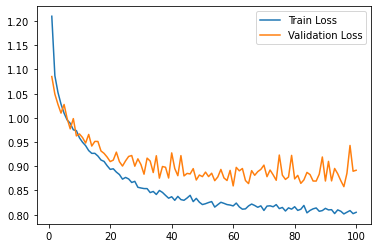

In [ ]:
epochs = range(1, 1+num_epochs)
plt.plot(epochs, train_metrics_history['total_loss'], label = "Train Loss")
plt.plot(epochs, val_metrics_history['total_loss'], label = "Validation Loss")
plt.legend()
plt.show()

### Train and Validation Accuracy

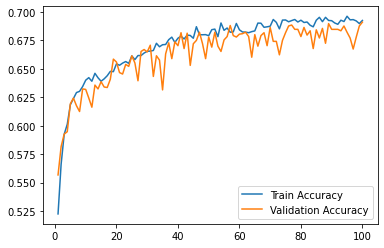

In [ ]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_metrics_history['accuracy'], label = "Train Accuracy")
plt.plot(epochs, val_metrics_history['accuracy'], label = "Validation Accuracy")
plt.legend()
plt.show()

### Per-Class Precision and Recall

#### Precision

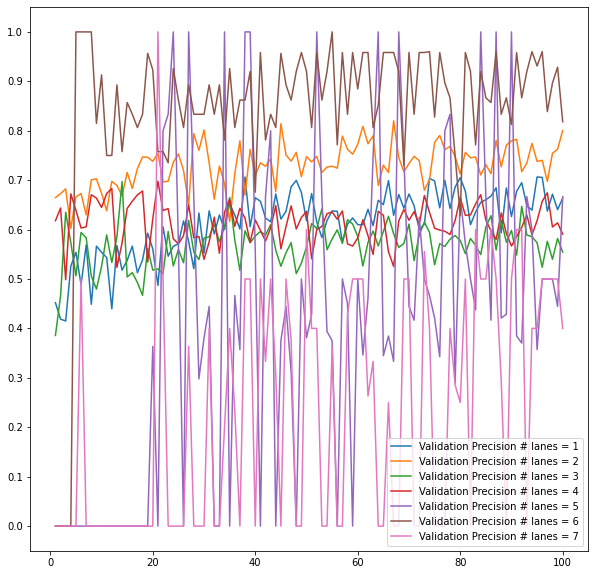

In [ ]:
epochs = range(1, num_epochs+1)
plt.figure(1, figsize=(10, 10))
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
for k in range(7):
  #plt.plot(epochs, train_metrics_history['precision_' + str(k)], label = "Train Precision # lanes = {}".format(k+1))
  plt.plot(epochs, val_metrics_history['precision_' + str(k)], label = "Validation Precision # lanes = {}".format(k+1))
plt.legend()
plt.show()

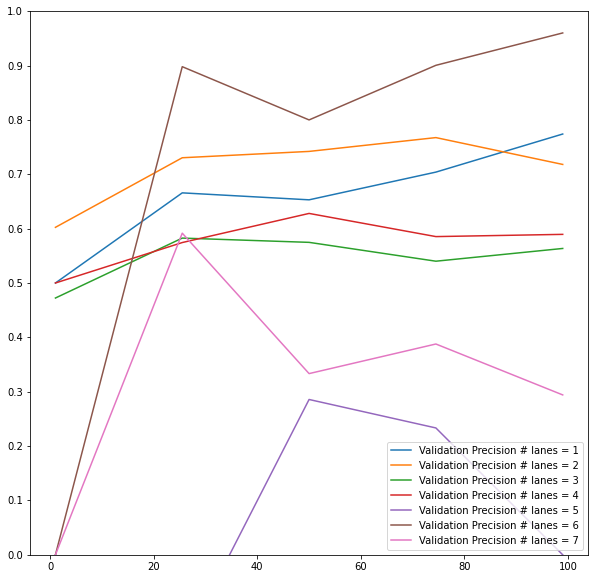

In [ ]:
# With Smoothing
import numpy as np
import scipy

epochs = range(1, num_epochs+1)


plt.figure(1, figsize=(10, 10))
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylim((0,1.0))
for k in range(7):
  x_new = np.linspace(1, 99, 5)
  spline = scipy.interpolate.make_interp_spline(epochs, val_metrics_history['precision_' + str(k)])
  y_new = spline(x_new)
  plt.plot(x_new, y_new, label = "Validation Precision # lanes = {}".format(k+1))
plt.legend()
plt.show()

#### Recall

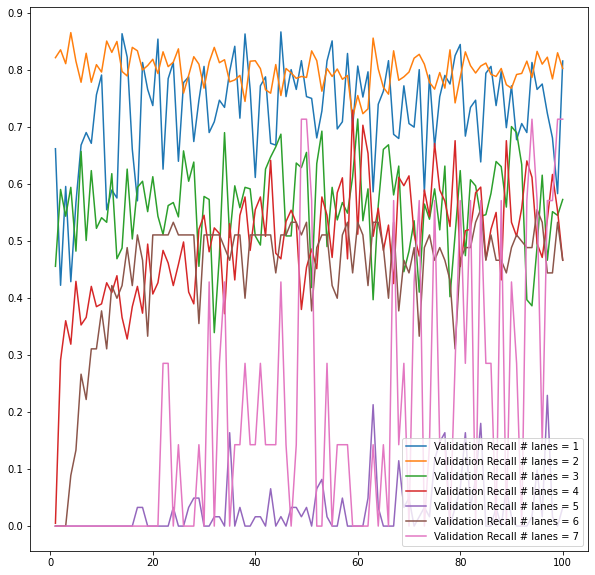

In [ ]:
epochs = range(1, num_epochs+1)
plt.figure(1, figsize=(10, 10))
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
for k in range(7):
  #plt.plot(epochs, train_metrics_history['recall_' + str(k)], label = "Train Recall # lanes = {}".format(k+1))
  plt.plot(epochs, val_metrics_history['recall_' + str(k)], label = "Validation Recall # lanes = {}".format(k+1))
plt.legend()
plt.show()

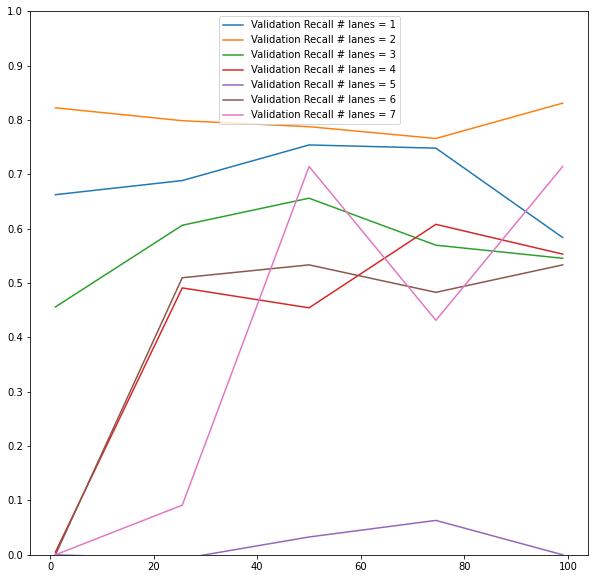

In [ ]:
# With Smoothing
import numpy as np
import scipy

epochs = range(1, num_epochs+1)


plt.figure(1, figsize=(10, 10))
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylim((0,1.0))
for k in range(7):
  x_new = np.linspace(1, 99, 5)
  spline = scipy.interpolate.make_interp_spline(epochs, val_metrics_history['recall_' + str(k)])
  y_new = spline(x_new)
  plt.plot(x_new, y_new, label = "Validation Recall # lanes = {}".format(k+1))
plt.legend()
plt.show()

## Baseline Model - Normal Deep Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.dropout = 0.0
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.stack(x)
        x = F.dropout(logits, self.dropout, training=self.training)
        return x

In [ ]:
neural_network = NeuralNetwork().to(device)
print(neural_network)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (stack): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=7, bias=True)
  )
)


In [ ]:
# Train
def nn_train(model, data, train_idx, optimizer, batch_size):
  model.train()
  total_loss = 0
  metrics = defaultdict(float)

  num_steps = len(train_idx) // batch_size

  for _ in range(num_steps):

    perm = torch.randperm(train_idx.size(0))
    indices = perm[:batch_size]
    batch_idx = train_idx[indices]

    labels = torch.squeeze(data.y[batch_idx])
    optimizer.zero_grad()
    out = model(data.x[batch_idx].float())
    loss = F.cross_entropy(out, labels)
    loss.backward()
    optimizer.step()
    total_loss += float(loss)

    prediction = out.argmax(dim=-1)
    batch_metrics = computeMetrics(prediction, labels)

    # Bookkeeping
    metrics['total_correct'] += batch_metrics['correct']
    for k in range(7):
      metrics['total_TP_' + str(k)] += batch_metrics['TP_' + str(k)]
      metrics['total_FP_' + str(k)] += batch_metrics['FP_' + str(k)]
      metrics['total_FN_' + str(k)] += batch_metrics['FN_' + str(k)]

  metrics['total_loss'] = total_loss / num_steps
  metrics['accuracy'] = metrics['total_correct'] / len(train_idx)
  for k in range(7):
    TP, FP, FN = metrics['total_TP_' + str(k)], metrics['total_FP_' + str(k)], metrics['total_FN_' + str(k)]
    metrics['precision_' + str(k)] = TP/(TP+FP) if TP+FP else 0
    metrics['recall_' + str(k)] = TP/(TP+FN) if TP+FN else 0

  return metrics

In [ ]:
# Validation
def nn_validate(model, data, val_idx, batch_size):
  total_loss = 0
  metrics = defaultdict(float)

  num_steps = len(val_idx) // batch_size

  for _ in range(num_steps):

    perm = torch.randperm(val_idx.size(0))
    indices = perm[:batch_size]
    batch_idx = val_idx[indices]

    labels = torch.squeeze(data.y[batch_idx])
    out = model(data.x[batch_idx].float())
    loss = F.cross_entropy(out, labels)
    total_loss += float(loss)

    prediction = out.argmax(dim=-1)
    batch_metrics = computeMetrics(prediction, labels)

    # Bookkeeping
    metrics['total_correct'] += batch_metrics['correct']
    for k in range(7):
      metrics['total_TP_' + str(k)] += batch_metrics['TP_' + str(k)]
      metrics['total_FP_' + str(k)] += batch_metrics['FP_' + str(k)]
      metrics['total_FN_' + str(k)] += batch_metrics['FN_' + str(k)]

  metrics['total_loss'] = total_loss / num_steps
  metrics['accuracy'] = metrics['total_correct'] / len(val_idx)
  for k in range(7):
    TP, FP, FN = metrics['total_TP_' + str(k)], metrics['total_FP_' + str(k)], metrics['total_FN_' + str(k)]
    metrics['precision_' + str(k)] = TP/(TP+FP) if TP+FP else 0
    metrics['recall_' + str(k)] = TP/(TP+FN) if TP+FN else 0

  return metrics

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


nn_lr = 0.01
nn_num_epochs = 100
batch_size = 64

# Model Instantiation
nn_model = NeuralNetwork()
nn_model.to(device)

# Use Adam optimizer to adapt learning rate.
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=nn_lr)


nn_train_metrics_history = defaultdict(list)
nn_val_metrics_history = defaultdict(list)
for epoch in range(1, 1 + nn_num_epochs):
  print("Epoch: ", epoch)
  nn_train_metrics = nn_train(nn_model, data, train_idx, nn_optimizer, batch_size)
  nn_val_metrics = nn_validate(nn_model, data, val_idx, batch_size)
  print("Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}".format(nn_train_metrics['total_loss'], nn_train_metrics['accuracy'], nn_val_metrics['total_loss'], nn_val_metrics['accuracy']))
  for metric_name, metric_value in nn_train_metrics.items():
    nn_train_metrics_history[metric_name].append(metric_value)
  for metric_name, metric_value in nn_val_metrics.items():
    nn_val_metrics_history[metric_name].append(metric_value)

Epoch:  1
Train Loss: 1.2066579561781239, Train Accuracy: 0.531405045919983, Val Loss: 1.133776988532092, Val Accuracy: 0.5225833685099198
Epoch:  2
Train Loss: 1.0752516437221218, Train Accuracy: 0.5703578591787185, Val Loss: 1.10870226009472, Val Accuracy: 0.5778809624314056
Epoch:  3
Train Loss: 1.0593213922268636, Train Accuracy: 0.5976987226855273, Val Loss: 1.0593011798085392, Val Accuracy: 0.5943436048965809
Epoch:  4
Train Loss: 1.053861920898025, Train Accuracy: 0.6029768816636757, Val Loss: 1.0969587371156022, Val Accuracy: 0.5854791051076403
Epoch:  5
Train Loss: 1.021696081032624, Train Accuracy: 0.6172279109046764, Val Loss: 1.0953715620814144, Val Accuracy: 0.5875897002954833
Epoch:  6
Train Loss: 1.0199369091439892, Train Accuracy: 0.6131109469017206, Val Loss: 1.0754928298898645, Val Accuracy: 0.5939214858590123
Epoch:  7
Train Loss: 1.0368948272756628, Train Accuracy: 0.6170167845455505, Val Loss: 1.0650504231452942, Val Accuracy: 0.597298438159561
Epoch:  8
Train Loss

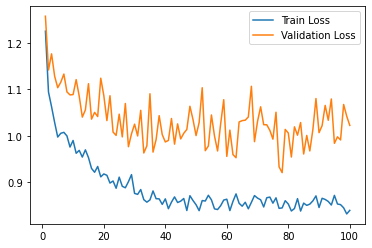

In [ ]:
epochs = range(1, 1+nn_num_epochs)
plt.plot(epochs, nn_train_metrics_history['total_loss'], label = "Train Loss")
plt.plot(epochs, nn_val_metrics_history['total_loss'], label = "Validation Loss")
plt.legend()
plt.show()

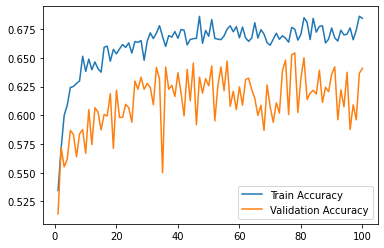

In [ ]:
epochs = range(1, nn_num_epochs+1)
plt.plot(epochs, nn_train_metrics_history['accuracy'], label = "Train Accuracy")
plt.plot(epochs, nn_val_metrics_history['accuracy'], label = "Validation Accuracy")
plt.legend()
plt.show()

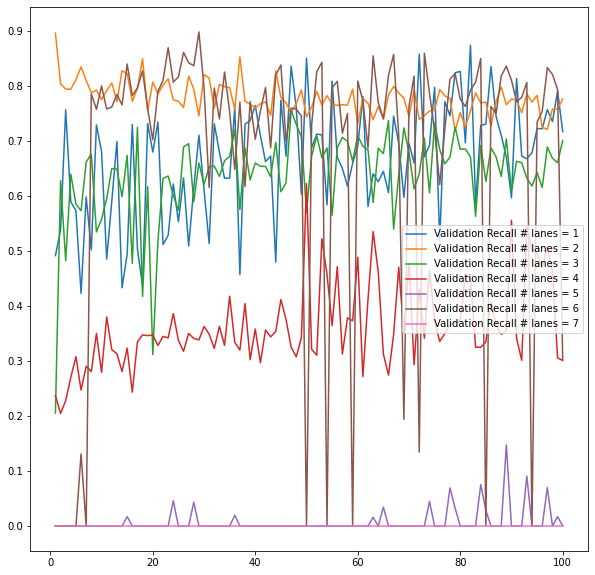

In [ ]:
epochs = range(1, nn_num_epochs+1)
plt.figure(1, figsize=(10, 10))
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
for k in range(7):
  #plt.plot(epochs, nn_train_metrics_history['recall_' + str(k)], label = "Train Recall # lanes = {}".format(k+1))
  plt.plot(epochs, nn_val_metrics_history['recall_' + str(k)], label = "Validation Recall # lanes = {}".format(k+1))
plt.legend()
plt.show()